## Portfolio Management Black-Litterman Model

Portfolio management involves creating and managing a diverse set of assets, such as stocks, bonds, and cash, to align with an investor's long-term financial objectives and risk tolerance. This process involves
* Investment Selection
* Asset Allocation
* Risk Management
* Performance Monitoring

There are different stratergies investors follow to find the optimal allocation of assets that maximizes the return while minimizing the risk. This is done by considering investor's financial goals of return and risk. By **diversifying** the assets across various investment avenues helps achieve an optimal balance of risk and reward.

There are several mathematical models that are used in this optimization problem. In this notebook we use the following model,


**Black-Litterman Model**

Combines investor views with market equilibrium to derive expected returns.
It is an extension of the mean-variance optimization model and addresses some of its limitations, such as sensitivity to input assumptions.

**Market Equilibrium Returns**

The BL model uses the "equilibrium" returns as a neutral starting point. The equilibrium (or implied) expected returns,$\pi$ are derived using the reverse optimization approach:

\begin{equation}
\pi = \lambda \cdot \Sigma \cdot \omega_m,
\end{equation}
where

$\lambda$: Risk aversion coefficient

$\Sigma$: Covariance matrix of asset return

$\omega_m$: Market capitalization weights of the assets.

**Investor Views**

Define the investor views on expected asset returns, in the form of " Asset 1 will outperform asset 2 by X%. These views are represented as:
$$ Q = P\cdot\mu,$$
where

$P$: Views matrix, defining the relationship between assets and views.Each row of $P$ indicates which assets are involved in a view.

$\mu$: Vector of returns

$Q$: Expected return values of the views.

For this project, I used moving averages of the returns to get an idea of how they will perform in the future and created views based on that.

**Confidence in Views $\Omega$.**

$\Omega$ is a diagonal matrix where each diagonal element corresponds to the confidence in each of the individual views in $Q$. The variance of an individual view is $p_k \Sigma p_k'$, where $p_k$ is a single row vector from the matix $P$ that corresponds to the $k^{th}$ view and $\Sigma$ is the covariance matix of returns. Then the entries in the matrix $\Omega$ are given by $\tau * p_k \Sigma p_k'$, where $\tau$ is the uncertainty in equilibrium returns.

The larger the value of Omega, the more confident you are in your view, and the more weight the view will have in the final optimized portfolio. If the value is small, it means you're less confident in the view, and the model will give less weight to it.

**Black Litterman formula**

The BL model combines market equilibrium returns ($\pi$) with investor views ($Q,P,\Omega$) using a Bayesian approach. The posterior distribution of asset returns ($E[R]$) is given by

$$E[R]=(\Sigma^{-1}+P^T\Omega^{-1}P)^{-1}\cdot(\Sigma^{-1}\pi+P^T\Omega^{-1}Q)$$


**Posterior covariance matrix of adjusted returns**

This new covariance matrix takes into account of the additional variance resulting from the investor views.  

$$\Sigma_{BL} = \Sigma + (\Sigma^{-1}+P^T\Omega^{-1}P)^{-1}$$.
With the new covariance matrix, we can then calculate the new portfolio weights.



In [ ]:
!pip install pypfopt

ERROR: Could not find a version that satisfies the requirement pypfopt (from versions: none)
ERROR: No matching distribution found for pypfopt


In [ ]:
#pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime, timedelta
#from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting


In [ ]:
# input = past n years data
def fetch_past_data(tickers, n):
  # to get previous n years of data
  end_date = datetime.today()
  start_date = end_date - timedelta(days = n*365)
  data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
  return data

In [ ]:
# Define tickers and time period
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN','TSLA']
start_date = '2018-01-01'
#end_date = '2023-01-01'

# Download data
data = fetch_past_data(tickers, 5)
returns = data.pct_change().dropna()


[*********************100%***********************]  5 of 5 completed


In [ ]:
returns

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2019-12-17,0.001965,0.012124,-0.004270,-0.005401,-0.006579
2019-12-18,-0.002389,-0.003703,-0.002199,-0.002068,0.037362
2019-12-19,0.001001,0.004624,0.003351,0.008681,0.027699
2019-12-20,-0.002071,-0.003225,-0.003848,0.010918,0.003836
2019-12-23,0.016318,0.003638,-0.000437,0.000000,0.033605
...,...,...,...,...,...
2024-12-06,-0.000823,0.029381,0.011990,0.002146,0.053398
2024-12-09,0.016101,-0.004140,0.004928,0.005523,0.001464
2024-12-10,0.004134,-0.004644,0.055882,-0.006031,0.028733


In [ ]:
# Calculate annualized expected returns and covariance matrix
expected_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

risk_free_rate = 0.03  # Risk-free rate for Sharpe ratio calculation

### Base Model - Equal weights

In [ ]:
# Number of assets in the portfolio
n_assets = len(tickers)

# Equal Weights (each asset gets 1/n weight)
equal_weights = np.ones(n_assets) / n_assets

# Compute the return of the equal-weighted portfolio
# The portfolio return is the dot product of the equal weights and the asset returns

portfolio_return = np.dot(equal_weights, expected_returns)  # Mean returns of assets

# Calculate the portfolio volatility (standard deviation) using the covariance matrix
portfolio_volatility = np.sqrt(np.dot(equal_weights.T, np.dot(cov_matrix, equal_weights)))

# Sharpe Ratio (assuming risk-free rate is available, e.g., `risk_free_rate`)
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

# Step 3: Print results
print("Equal-Weighted Portfolio:")
print(f"Portfolio Return: {portfolio_return:.4f}")
print(f"Portfolio Volatility: {portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


Equal-Weighted Portfolio:
Portfolio Return: 0.3776
Portfolio Volatility: 0.3161
Sharpe Ratio: 1.0997


# Black Litterman

### Market capitalization weights

In [ ]:
mcaps = {}
for t in tickers:
    mcaps[t] = yf.Ticker(t).info['marketCap']
mcaps
mcap_weights = {k: v / sum(mcaps.values()) for k, v in mcaps.items()}
mcap_weights
market_cap_weights = np.array(list(mcap_weights.values()))

In [ ]:
market_cap_weights

array([0.28233439, 0.25395599, 0.1796412 , 0.182108  , 0.10196042])

In [ ]:
# Fetch market cap data
market_caps = []
for ticker in tickers:
    stock = yf.Ticker(ticker)
    info = stock.info
    try:
        market_cap = info['sharesOutstanding'] * info['currentPrice']  # Calculate Market Cap
        market_caps.append(market_cap)
    except KeyError:
        print(f"Market cap data not available for {ticker}")

# Calculate market cap weights
market_caps = np.array(market_caps)
market_cap_weights = market_caps / np.sum(market_caps)
market_cap_weights

array([0.31167143, 0.28036369, 0.09437418, 0.20103568, 0.11255502])

### Risk-free rate  - Here I use 3 months Treasury bill rate as the risk free rate.

In [ ]:
# Calculate the start date (3 months before today)
end_date = datetime.today()
start_date = end_date - timedelta(days=90)  # Approximation of 3 months

# Format dates to strings in 'YYYY-MM-DD' format
start_date_str = start_date.strftime("%Y-%m-%d")
end_date_str = end_date.strftime("%Y-%m-%d")

# Fetch 3-month Treasury bill data (risk-free rate proxy)
risk_free_data = yf.download("^IRX", start=start_date_str, end=end_date_str)
risk_free_rate = risk_free_data['Close'].mean() / 100
risk_free_rate = risk_free_rate.iloc[-1]

[*********************100%***********************]  1 of 1 completed


Since ^IRX represents a yield rather than a tradable security price, there is no need for an adjusted value (like Adj Close) because there are no stock splits, dividends, or other corporate actions that apply.

The Adj Close is primarily relevant for equity securities like stocks. It adjusts the historical prices to account for stock splits, dividends, and similar events, ensuring a more accurate representation of the asset's total return over time.

For ^IRX, these adjustments are not applicable since it's not a stock or an asset with dividend payouts or splits.

### Risk aversion coefficient - $\lambda$ lambda
**High risk** $\lambda$ = 10

**Moderate risk** $\lambda$ = 2

**Low risk** $\lambda$ = 0.5

In [ ]:
lamda = 2

### Market Equilibrium Returns

In [ ]:
# Calculate market equilibrium returns
Pi = lamda * np.dot(cov_matrix, market_cap_weights) #market equilibrium_returns

### Investor Views

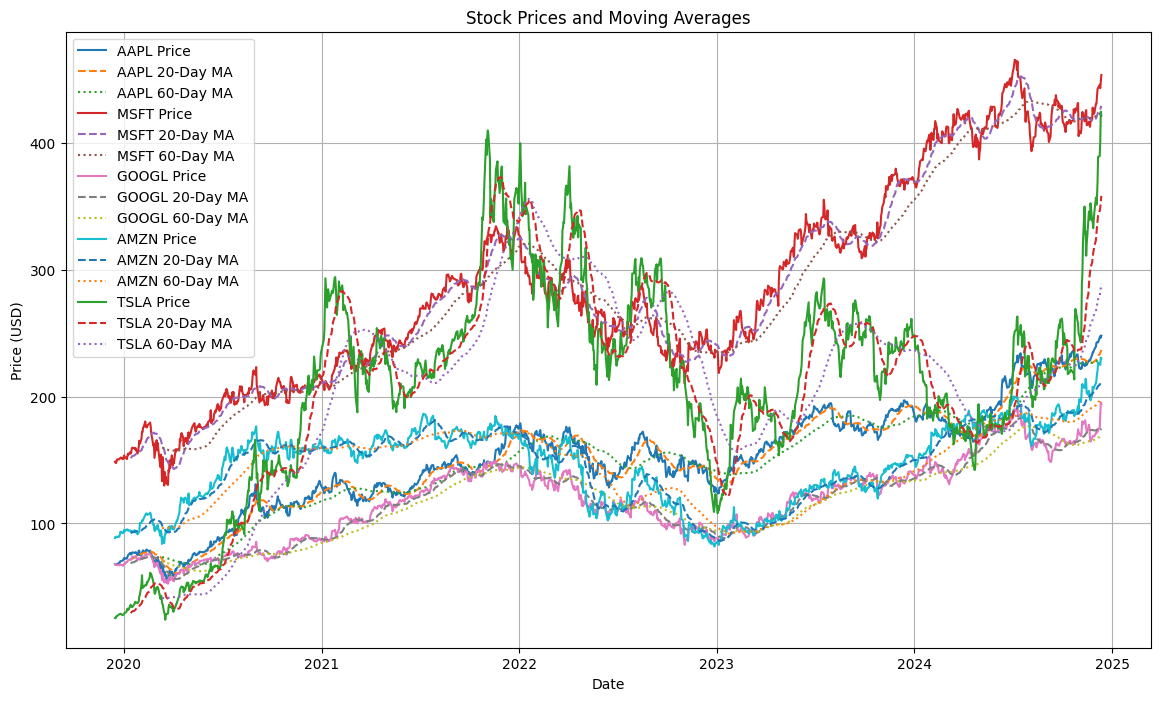

In [ ]:
# Define moving average window sizes
short_window = 20  # Short-term moving average
long_window = 60  # Long-term moving average

# Plot the price and moving averages for each ticker
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(data[ticker], label=f"{ticker} Price")
    plt.plot(data[ticker].rolling(window=short_window).mean(), linestyle='--', label=f"{ticker} {short_window}-Day MA")
    plt.plot(data[ticker].rolling(window=long_window).mean(), linestyle=':', label=f"{ticker} {long_window}-Day MA")

# Add labels, legend, and grid
plt.title('Stock Prices and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left', fontsize=10)
plt.grid()
plt.show()

In [ ]:
# Calculate moving averages
short_window = 20  # Short-term moving average
long_window = 60   # Long-term moving average

# Create a DataFrame to store the signals
ma_df = pd.DataFrame(index=data.index)
for ticker in tickers:
    ma_df[f"{ticker}_short"] = data[ticker].rolling(window=short_window).mean()
    ma_df[f"{ticker}_long"] = data[ticker].rolling(window=long_window).mean()

# Generate views based on moving average crossovers
views = []
for i, ticker1 in enumerate(tickers):
    for j, ticker2 in enumerate(tickers):
        if i < j:
            # Compare moving averages of two assets
            avg1 = ma_df[f"{ticker1}_short"].iloc[-1] - ma_df[f"{ticker1}_long"].iloc[-1]
            avg2 = ma_df[f"{ticker2}_short"].iloc[-1] - ma_df[f"{ticker2}_long"].iloc[-1]

            # If short MA > long MA, expect better performance
            if avg1 > avg2:
                views.append((ticker1, ticker2, avg1 - avg2))  # View: ticker1 > ticker2
            elif avg2 > avg1:
                views.append((ticker2, ticker1, avg2 - avg1))  # View: ticker2 > ticker1
print(views)
# Create P matrix and Q vector
P = []
Q = []
for view in views:
    row = [0] * len(tickers)
    row[tickers.index(view[0])] = 1  # Positive for the first asset
    row[tickers.index(view[1])] = -1  # Negative for the second asset
    P.append(row)
    Q.append(view[2] / data.iloc[-1].mean())  # to scale down the views to be in the same scale as the data's return


P = np.array(P)
Q = np.array(Q)
#print(Q)
# Print results
print("Generated Views:")
for i, view in enumerate(views):
    print(f"{view[0]} will outperform {view[1]} by {view[2]:.2f} (scaled to {Q[i]:.4f})")

print("\nP Matrix:\n", P)
print("\nQ Vector:\n", Q)

[('AAPL', 'MSFT', 0.2669878641764001), ('AAPL', 'GOOGL', 0.6986900329589787), ('AMZN', 'AAPL', 7.761115519205731), ('TSLA', 'AAPL', 63.63723882039389), ('MSFT', 'GOOGL', 0.4317021687825786), ('AMZN', 'MSFT', 8.028103383382131), ('TSLA', 'MSFT', 63.90422668457029), ('AMZN', 'GOOGL', 8.45980555216471), ('TSLA', 'GOOGL', 64.33592885335287), ('TSLA', 'AMZN', 55.87612330118816)]
Generated Views:
AAPL will outperform MSFT by 0.27 (scaled to 0.0009)
AAPL will outperform GOOGL by 0.70 (scaled to 0.0023)
AMZN will outperform AAPL by 7.76 (scaled to 0.0251)
TSLA will outperform AAPL by 63.64 (scaled to 0.2055)
MSFT will outperform GOOGL by 0.43 (scaled to 0.0014)
AMZN will outperform MSFT by 8.03 (scaled to 0.0259)
TSLA will outperform MSFT by 63.90 (scaled to 0.2064)
AMZN will outperform GOOGL by 8.46 (scaled to 0.0273)
TSLA will outperform GOOGL by 64.34 (scaled to 0.2078)
TSLA will outperform AMZN by 55.88 (scaled to 0.1805)

P Matrix:
 [[ 1 -1  0  0  0]
 [ 1  0 -1  0  0]
 [-1  0  0  1  0]
 [

### Calculate the Omega Matrix

In [ ]:
def calculate_omega(returns, cov_matrix, views):
    """
    Calculate the Omega matrix for Black-Litterman views.

    Parameters:
    - returns: DataFrame with historical returns of assets (columns are asset names).
    - views: List of tuples, where each tuple represents a view in the form:
             ("Asset A", "Asset B")
             Example: [("AAPL", "MSFT"), ("GOOG", "AMZN")]
    - cov_matrix: Covariance matrix of asset returns.
    Returns:
    - Omega: Diagonal matrix with uncertainty levels (variances) for each view.
    """
    omega = np.zeros((len(views), len(views)))

    for i in range(len(views)):
      omega[i,i] = np.dot(np.dot(P[i,:],cov_matrix),P[i,:].T)
    return omega

In [ ]:
tau = 0.025  # Uncertainty in equilibrium returns
omega = calculate_omega(returns, cov_matrix, views)*tau
omega

array([[0.00236963, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00180438, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00122076, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00858848, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00209511,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00184514, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00924731, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

### Calculate the adjusted expected returns (E[R])

In [ ]:
tau = 0.025  # Uncertainty in equilibrium returns

inv_tau_cov = np.linalg.inv(tau * cov_matrix)
inv_omega = np.linalg.inv(omega)
term1 = np.linalg.inv(inv_tau_cov + np.dot(np.dot(P.T, inv_omega), P))
term2 = np.dot(inv_tau_cov, Pi) + np.dot(np.dot(P.T, inv_omega), Q)
adjusted_returns = np.dot(term1, term2)

### Adjusted covariance matrix (Sigma_BL)

In [ ]:
adjusted_cov_matrix = cov_matrix + term1

### Optimize portfolio weights using mean-variance optimization

In [ ]:
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.03):
    port_return, port_volatility = portfolio_performance(weights, returns, cov_matrix)
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility
    return -sharpe_ratio

# Constraints: Weights sum to 1, no short selling
num_assets = len(tickers)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_weights = np.array([1. / num_assets] * num_assets)

# Optimize for maximum Sharpe ratio
result = minimize(negative_sharpe_ratio, initial_weights,
                  args=(adjusted_returns, adjusted_cov_matrix),
                  bounds=bounds, constraints=constraints)

optimal_weights = result.x


Posterior Returns (Black-Litterman Adjusted):
AAPL: 0.1632
MSFT: 0.1660
GOOGL: 0.1559
AMZN: 0.1747
TSLA: 0.3447

Optimal Portfolio Weights:
AAPL: 0.0657
MSFT: 0.0343
GOOGL: 0.0253
AMZN: 0.5800
TSLA: 0.2947

Optimal Portfolio Performance:
Return: 0.2233
Volatility: 0.3499
Sharpe Ratio: 0.5106


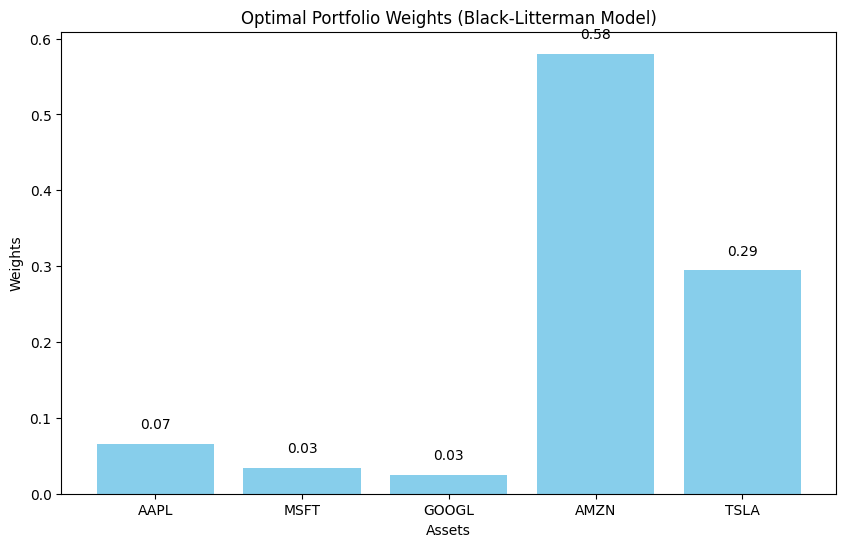

In [ ]:
# Extract results
optimal_weights = result.x
optimal_return, optimal_volatility = portfolio_performance(optimal_weights, adjusted_returns, adjusted_cov_matrix)
optimal_sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

# Display Results
print("Posterior Returns (Black-Litterman Adjusted):")
for ticker, ret in zip(tickers, adjusted_returns):
    print(f"{ticker}: {ret:.4f}")

print("\nOptimal Portfolio Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print(f"\nOptimal Portfolio Performance:")
print(f"Return: {optimal_return:.4f}")
print(f"Volatility: {optimal_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

# Plot Portfolio Weights
def plot_weights(weights, tickers, title):
    plt.figure(figsize=(10, 6))
    plt.bar(tickers, weights, color='skyblue')
    plt.xlabel('Assets')
    plt.ylabel('Weights')
    plt.title(title)
    for i, w in enumerate(weights):
        plt.text(i, w + 0.02, f"{w:.2f}", ha='center')
    plt.show()

plot_weights(optimal_weights, tickers, "Optimal Portfolio Weights (Black-Litterman Model)")